In [74]:
import timeit

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [75]:
data_dir = "data/validate_data"
fig_dir = "figures/validate_data"
!mkdir -p {data_dir}
!mkdir -p {fig_dir}

In [76]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset = (3 + rank) * 32 // nbits
    data = np.fromfile(
        filename,
        dtype=np.float32 if nbits == 32 else np.float64,
        count=nz * ny * nx + offset,
    )
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))


def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file("in_field.dat")
    im1 = axs[0].imshow(
        in_field[in_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im1, ax=axs[0])
    axs[0].set_title("Initial condition")

    out_field = read_field_from_file("out_field.dat")
    im2 = axs[1].imshow(
        out_field[out_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im2, ax=axs[1])
    axs[1].set_title("Final result")

    plt.show()

# Compile base version (structured)
As a baseline

In [77]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=base

rm -f *.out weak.txt caching.txt caching2.txt out.txt 
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report report_*.txt out.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-base.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-base.o -o stencil2d-base.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-base.x' (lite-samples) ...OK


cp stencil2d-base.x stencil2d.x


In [78]:
%%bash
srun -n 1 ./stencil2d-base.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024

# ranks nx ny ny nz num_iter time
data = np.array( [ \
[    1,  128,  128,   64,    1024,  0.8286510E+00], \
] )


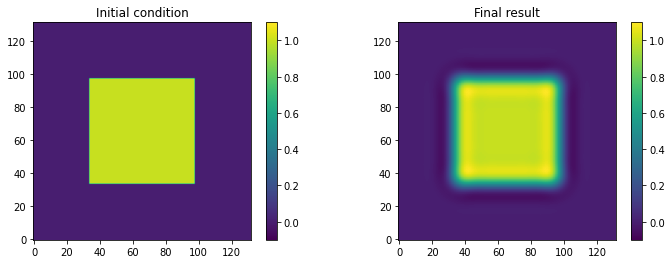

In [79]:
validate_results()

In [80]:
!mv in_field.dat {data_dir}/in_field_structured.dat
!mv out_field.dat {data_dir}/out_field_structured.dat

# Compile sequential

In [81]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=sequential

rm -f *.out weak.txt caching.txt caching2.txt out.txt 
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report report_*.txt out.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-sequential.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-sequential.o -o stencil2d-sequential.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-sequential.x' (lite-samples) ...OK


cp stencil2d-sequential.x stencil2d.x


In [82]:
%%bash
srun -n 1 ./stencil2d-sequential.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024

# ranks nx ny nz num_iter time
data = np.array( [ \
[    1,  128,  128,   64,    1024,  0.5011492E+01], \
] )


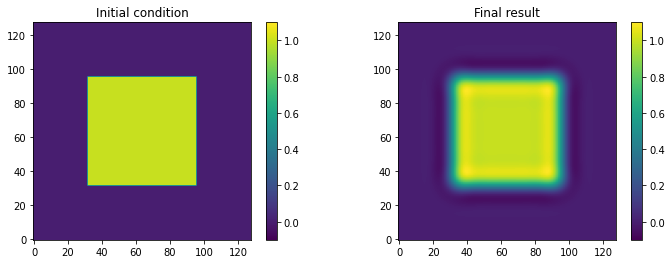

In [84]:
validate_results()

In [85]:
!mv in_field.dat {data_dir}/in_field_sequential.dat
!mv out_field.dat {data_dir}/out_field_sequential.dat

# Compare structured and unstructured

In [121]:
# read the in_field and out_field from structured and unstructured grid
out_structured = read_field_from_file(f"{data_dir}/out_field_structured.dat")
out_unstructured = read_field_from_file(f"{data_dir}/out_field_sequential.dat")

in_structured = read_field_from_file(f"{data_dir}/in_field_structured.dat")
in_unstructured = read_field_from_file(f"{data_dir}/in_field_sequential.dat")

In [122]:
# structured grid includes the halo points (need to exclude them in the plot)
out_structured[:,2:132-2,2:132-2].shape

(64, 128, 128)

In [123]:
# shape of unstructured grid
out_unstructured.shape

(64, 128, 128)

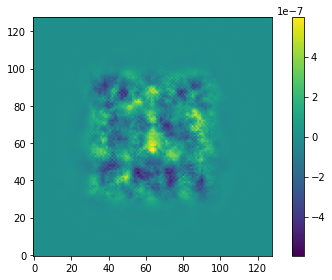

In [124]:
# plot any deviation between structured and unstructured
fig = plt.figure()
ax = fig.add_subplot()
im = ax.imshow((out_structured[32 , 2:132-2 , 2:132-2] - out_unstructured[32,:,:]) , origin="lower")
fig.colorbar(im, ax=ax)
fig.tight_layout()
fig.savefig(f"{fig_dir}/diff_struc_unstruc.png")

Very minor deviation.<br>
Precision of 4-byte data = 7 decimal point of precision: https://en.wikipedia.org/wiki/Floating-point_arithmetic#:~:text=Single%20precision%20(binary32)%2C%20usually%20used%20to%20represent%20the%20%22float%22%20type%20in%20the%20C%20language%20family.%20This%20is%20a%20binary%20format%20that%20occupies%2032%20bits%20(4%20bytes)%20and%20its%20significand%20has%20a%20precision%20of%2024%20bits%20(about%207%20decimal%20digits)

# Try out another precision
change to 8-byte in the Fortran scripts

In [106]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=base

rm -f *.out weak.txt caching.txt caching2.txt out.txt 
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report report_*.txt out.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-base.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-base.o -o stencil2d-base.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-base.x' (lite-samples) ...OK


cp stencil2d-base.x stencil2d.x


In [107]:
%%bash
srun -n 1 ./stencil2d-base.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024

# ranks nx ny ny nz num_iter time
data = np.array( [ \
[    1,  128,  128,   64,    1024,  0.1564947E+01], \
] )


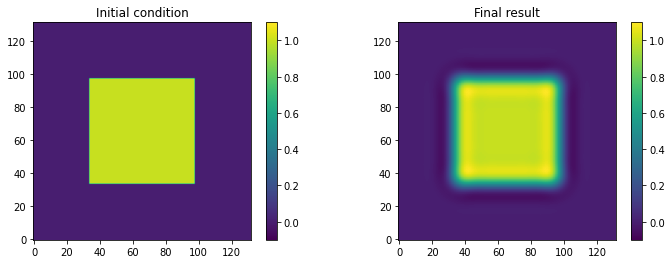

In [108]:
validate_results()

In [109]:
!mv in_field.dat {data_dir}/in_field_structured_8B.dat
!mv out_field.dat {data_dir}/out_field_structured_8B.dat

In [110]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=sequential

rm -f *.out weak.txt caching.txt caching2.txt out.txt 
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report report_*.txt out.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-sequential.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-sequential.o -o stencil2d-sequential.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-sequential.x' (lite-samples) ...OK


cp stencil2d-sequential.x stencil2d.x


In [111]:
%%bash
srun -n 1 ./stencil2d-sequential.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024

# ranks nx ny nz num_iter time
data = np.array( [ \
[    1,  128,  128,   64,    1024,  0.4981764E+01], \
] )


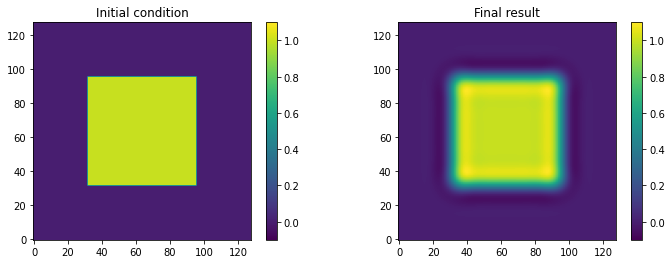

In [112]:
validate_results()

In [113]:
!mv in_field.dat {data_dir}/in_field_sequential_8B.dat
!mv out_field.dat {data_dir}/out_field_sequential_8B.dat

## plot the diff.

In [125]:
# read the in_field and out_field from structured and unstructured grid
out_structured = read_field_from_file(f"{data_dir}/out_field_structured_8B.dat")
out_unstructured = read_field_from_file(f"{data_dir}/out_field_sequential_8B.dat")

in_structured = read_field_from_file(f"{data_dir}/in_field_structured_8B.dat")
in_unstructured = read_field_from_file(f"{data_dir}/in_field_sequential_8B.dat")

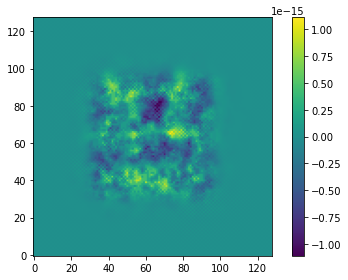

In [126]:
# plot any deviation between structured and unstructured
fig = plt.figure()
ax = fig.add_subplot()
im = ax.imshow((out_structured[32 , 2:132-2 , 2:132-2] - out_unstructured[32,:,:]) , origin="lower")
fig.colorbar(im, ax=ax)
fig.tight_layout()
fig.savefig(f"{fig_dir}/diff_struc_unstruc_8B.png")

# Compile random mapping

In [92]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=random

rm -f *.out weak.txt caching.txt caching2.txt out.txt 
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report report_*.txt out.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-random.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-random.o -o stencil2d-random.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-random.x' (lite-samples) ...OK


cp stencil2d-random.x stencil2d.x


In [93]:
%%bash
srun -n 1 ./stencil2d-random.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024

# ranks nx ny nz num_iter time
data = np.array( [ \
[    1,  128,  128,   64,    1024,  0.5843926E+01], \
] )


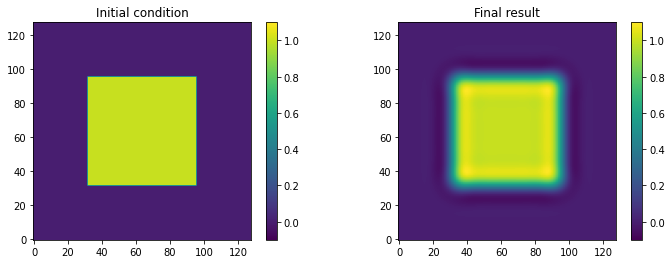

In [94]:
validate_results()

In [95]:
!mv in_field.dat {data_dir}/in_field_random.dat
!mv out_field.dat {data_dir}/out_field_random.dat

In [96]:
out_random = read_field_from_file(f"{data_dir}/out_field_random.dat")
out_sequential = read_field_from_file(f"{data_dir}/out_field_sequential.dat")

In [97]:
# count if random and sequential have the same output
np.sum((out_random[:,:,:] - out_sequential[:,:,:]) != 0)

0

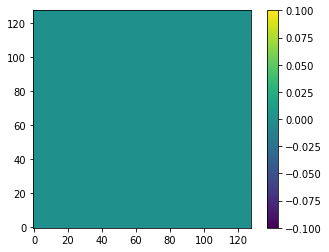

In [98]:
fig = plt.figure()
ax = fig.add_subplot()
im = ax.imshow((out_random[32, : , :] - out_sequential[32,:,:]) , origin="lower")
fig.colorbar(im, ax=ax)

# Compile Hilbert curve

In [99]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=hilbert

rm -f *.out weak.txt caching.txt caching2.txt out.txt 
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report report_*.txt out.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-hilbert.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-hilbert.o -o stencil2d-hilbert.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-hilbert.x' (lite-samples) ...OK


cp stencil2d-hilbert.x stencil2d.x


In [100]:
%%bash
srun -n 1 ./stencil2d-hilbert.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024

# ranks nx ny nz num_iter time
data = np.array( [ \
[    1,  128,  128,   64,    1024,  0.5160113E+01], \
] )


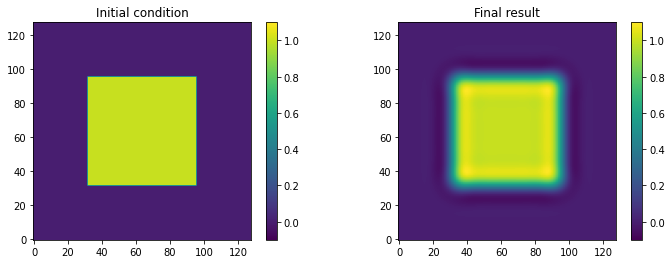

In [101]:
validate_results()

In [102]:
!mv in_field.dat {data_dir}/in_field_hilbert.dat
!mv out_field.dat {data_dir}/out_field_hilbert.dat

In [103]:
out_hilbert = read_field_from_file(f"{data_dir}/out_field_hilbert.dat")
out_sequential = read_field_from_file(f"{data_dir}/out_field_sequential.dat")

In [104]:
# count if hilbert version and sequential have the same output
np.sum((out_hilbert[:,:,:] - out_sequential[:,:,:]) != 0)

0

clear all executables

In [127]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean

rm -f *.out weak.txt caching.txt caching2.txt out.txt 
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report report_*.txt out.txt
